# Системы сбора событий и логов. Практическая работа №2.
## Тема: Анализ логов
## Выполнил Росляков Владислав Александрович. ББМО-01-23
#### Вариант №7: 22 % 16 + 1 = 7. HealthApp

In [1]:
# Клонирование репозитория с логами
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 575 (delta 145), reused 135 (delta 132), pack-reused 404 (from 1)
Receiving objects: 100% (575/575), 7.27 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (267/267), done.


Лог HealthApp выглядит следующим образом:
## 20171223-22:15:29:606|Step_LSC|30002312|onStandStepChanged 3579

### - 20171223-22:15:29:606:

Это временная метка, указывающая на дату и время события.
##### Формат: YYYYMMDD-HH:MM:SS:MS
* 2017 - год
* 12 - месяц (декабрь)
* 23 - день
* 22 - часы (в 24-часовом формате)
* 15 - минуты - 29 - секунды
* 606 - миллисекунды

### - Step_LSC:

* Это имя или идентификатор компонента или модуля, который генерирует этот лог. В данном случае, это может указывать на модуль, связанный с шагами (например, отслеживание шагов).

### - 30002312:

* Это идентификатор пользователя, устройства или сессии. Он может использоваться для отслеживания действий конкретного пользователя или устройства в системе.

### - onStandStepChanged 3579:

* Это сообщение, которое описывает событие. - onStandStepChanged может указывать на то, что произошло изменение в состоянии шагов (например, пользователь встал или изменил свою активность).
* 3579 - это, вероятно, значение, связанное с событием. Это может быть количество шагов, идентификатор события или другая метрика, связанная с изменением состояния.
 ## 5 видов сообщений
* 20171223-22:15:29:606|Step_LSC|30002312|onStandStepChanged 3579
* 20171223-22:16:00:123|Step_LSC|30002313|onStandStepChanged 3580
* 20171223-22:16:30:456|Error|30002312|Failed to update user data
* 20171223-22:17:00:789|Warning|30002314|Battery level low
* 20171223-22:17:30:012|Info|30002312|User  logged out

## Установка и Импорт Необходимых Библиотек

In [55]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import re
from google.colab import files

## Загрузка файла

In [56]:

uploaded = files.upload()
logs_path = next(iter(uploaded))

Saving HealthApp_2k.log to HealthApp_2k (1).log


## Парсинг Лог-Файла

In [57]:
def parse_log_line(line):
    pattern = r'(\d{8}-\d{2}:\d{2}:\d{2}:\d{3})\|(\w+)\|(\d+)\|(.+)'
    match = re.match(pattern, line)
    if match:
        return {
            'timestamp': match.group(1),
            'level': match.group(2),
            'user_id': match.group(3),
            'message': match.group(4),
        }
    return None

def parse_logs(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [parse_log_line(line) for line in lines if parse_log_line(line)]

logs = parse_logs(logs_path)
df_logs = pd.DataFrame(logs)

## Сохранение Записей в Базу Данных

In [58]:
conn = sqlite3.connect('logs.db')

# сохраняем необработанные данные
df_logs.to_sql('raw_logs', conn, if_exists='replace', index=False)

1368

## Нормализация Логов

In [59]:
# функция нормализации времени
def normalize_timestamp(timestamp):
    from datetime import datetime
    return datetime.strptime(timestamp, '%Y%m%d-%H:%M:%S:%f')

df_logs['timestamp'] = df_logs['timestamp'].apply(normalize_timestamp)

## Сохранение Нормализованных Данных

In [60]:
# анализ по уровню логирования
log_levels = df_logs['level'].value_counts()
print("Распределение уровней логирования:", log_levels)

# анализ частоты событий
df_logs['hour'] = df_logs['timestamp'].dt.hour
event_frequency = df_logs.groupby('hour').size()
print("Частота событий по часам:", event_frequency)

Распределение уровней логирования: level
Step_LSC                       428
Step_SPUtils                   348
Step_ExtSDM                    346
Step_StandReportReceiver       130
HiH_HiSyncControl               34
HiH_DataStatManager             17
Step_StandStepCounter           13
HiH_HiHealthDataInsertStore     11
HiH_HiHealthBinder               9
Step_FlushableStepDataCache      8
HiH_HiAppUtil                    8
HiH_                             8
HiH_HiBroadcastUtil              4
HiH_ListenerManager              2
HiH_HiSyncUtil                   2
Name: count, dtype: int64
Частота событий по часам: hour
22    983
23    385
dtype: int64


## Статистический Анализ

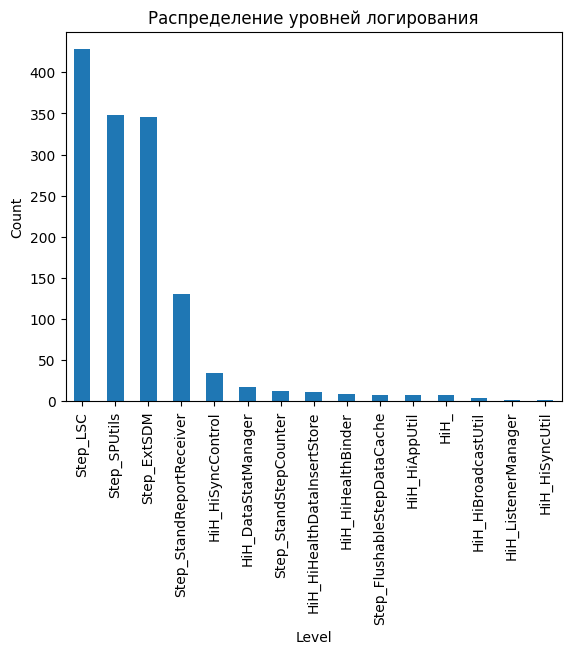

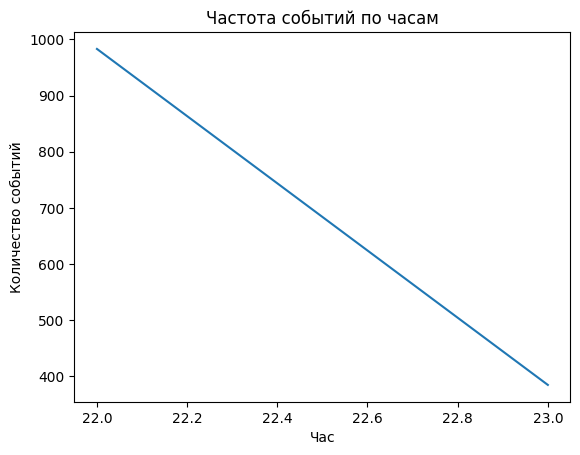

In [61]:
# визуализация уровней логирования
log_levels.plot(kind='bar')
plt.title('Распределение уровней логирования')
plt.xlabel('Level')
plt.ylabel('Count')
plt.show()

# визуализация частоты событий по часам
event_frequency.plot(kind='line')
plt.title('Частота событий по часам')
plt.xlabel('Час')
plt.ylabel('Количество событий')
plt.show()